In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_c57.npy', allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [5]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch, table='energy')

In [6]:
data_ncells = pd.read_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'_energy.csv')

# Apply task PLS for all areas and energy

In [7]:
%%bash
python area_pls.py -i results_pls/c57_n_cells.csv -o './results_pls/c57'

2023-05-08 16:17:22 PC1QFRRQ __main__[23177] INFO reading data...
2023-05-08 16:17:22 PC1QFRRQ __main__[23177] INFO computing PLS...
2023-05-08 16:17:22 PC1QFRRQ __main__[23177] INFO PLS computed, now performing bootstrap...
2023-05-08 16:17:22 PC1QFRRQ __main__[23177] INFO saving output data...


In [33]:
# %%bash
# python area_pls.py -i results_pls/c57_energy.csv -o './results_pls/c57_energy'

# Plot results

In [9]:
c57_contrasts = pd.read_csv('./results_pls/c57_contrasts.csv')
c57_saliences = pd.read_csv('./results_pls/c57_saliences.csv')
c57_contrasts = c57_contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

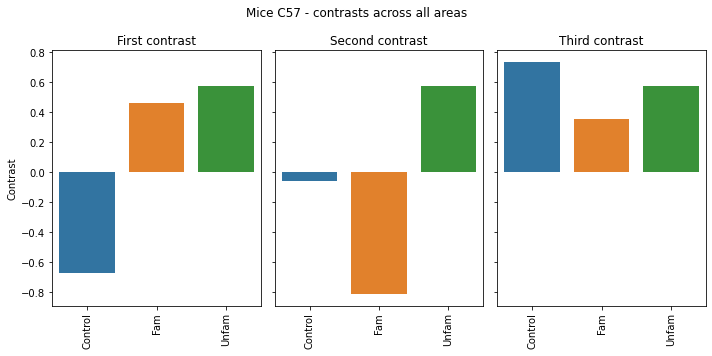

In [38]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.single_plot(df_data=c57_contrasts, index=0, ax=axes[0])
upls.single_plot(df_data=c57_contrasts, index=1, ax=axes[1])
upls.single_plot(df_data=c57_contrasts, index=2, ax=axes[2])
axes[0].set_ylabel('Contrast')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
fig.suptitle('Mice C57 - contrasts across all areas')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_contrasts_all_areas.png')
plt.savefig('./results_pls/c57_pls_contrasts_all_areas.svg')

# TODO: color code areas at level 5

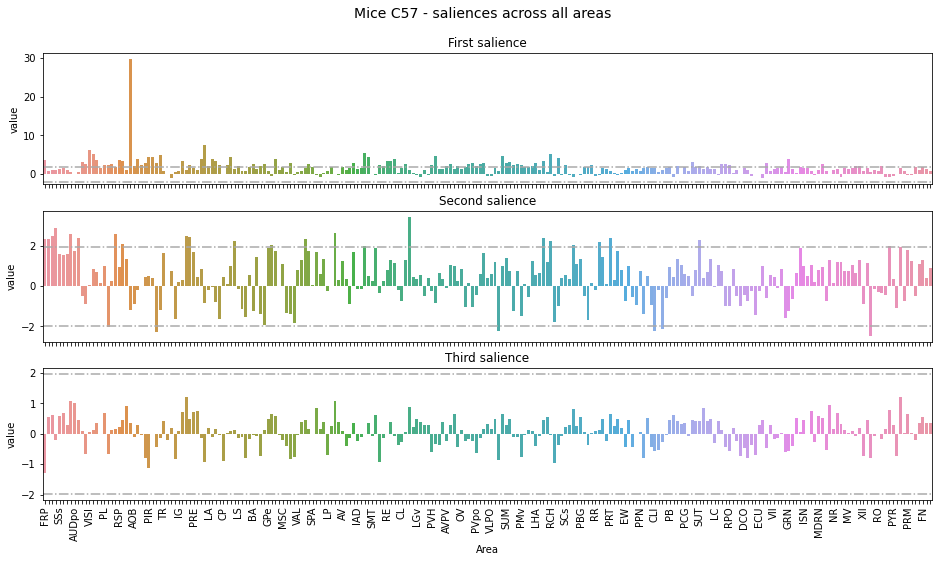

In [51]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=c57_saliences, index=0, ax=axes[0])
upls.single_plot(df_data=c57_saliences, index=1, ax=axes[1])
upls.single_plot(df_data=c57_saliences, index=2, ax=axes[2])
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
# plt.tight_layout()
fig.suptitle('Mice C57 - saliences across all areas', fontsize=14)
plt.savefig('./results_pls/c57_pls_saliences_all_areas.png')
plt.savefig('./results_pls/c57_pls_saliences_all_areas.svg')

In [12]:
c57_saliences.loc[0].max(), c57_saliences.idxmax(axis=1)

(29.660732196949333,
 0    MOB
 1     RT
 2    PAR
 dtype: object)

In [13]:
c57_saliences['MOB'].loc[0]

29.660732196949333

In [14]:
volumes.loc[volumes['acronym'] == 'MOB']['safe_name'].values[0]

'Main olfactory bulb'

# Identify areas with significant salience contribution

In [15]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=c57_saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)

In [49]:

# saliences = c57_saliences
# threshold=1.96
# # print areas over the saliences threshold
# threshold1 = threshold
# out1 = saliences.gt(threshold1).apply(lambda x: x.index[x].tolist(), axis=1).to_list()
# threshold2 = -threshold
# out2 = saliences.lt(threshold2).apply(lambda x: x.index[x].tolist(), axis=1).to_list()

# out1[1]

In [48]:
# for area in out1[0]:
#     print(volumes.loc[volumes['acronym'] == area]['safe_name'].values[0])

# Apply PLS for all significant areas in ncells and energy

In [19]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'_energy_filt.csv')

In [20]:
%%bash
python area_pls.py -i results_pls/c57_n_cells_filt.csv -o './results_pls/c57_filt'

2023-05-08 16:17:55 PC1QFRRQ __main__[23209] INFO reading data...
2023-05-08 16:17:55 PC1QFRRQ __main__[23209] INFO computing PLS...
2023-05-08 16:17:55 PC1QFRRQ __main__[23209] INFO PLS computed, now performing bootstrap...
2023-05-08 16:17:55 PC1QFRRQ __main__[23209] INFO saving output data...


In [21]:
%%bash
python area_pls.py -i results_pls/c57_energy_filt.csv -o './results_pls/c57__energy_filt'

2023-05-08 16:17:57 PC1QFRRQ __main__[23214] INFO reading data...
2023-05-08 16:17:57 PC1QFRRQ __main__[23214] INFO computing PLS...
2023-05-08 16:17:57 PC1QFRRQ __main__[23214] INFO PLS computed, now performing bootstrap...
2023-05-08 16:17:58 PC1QFRRQ __main__[23214] INFO saving output data...


In [22]:
c57_contrasts_filt = pd.read_csv('./results_pls/c57_filt_contrasts.csv')
c57_saliences_filt = pd.read_csv('./results_pls/c57_filt_saliences.csv')
c57_contrasts_filt = c57_contrasts_filt.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

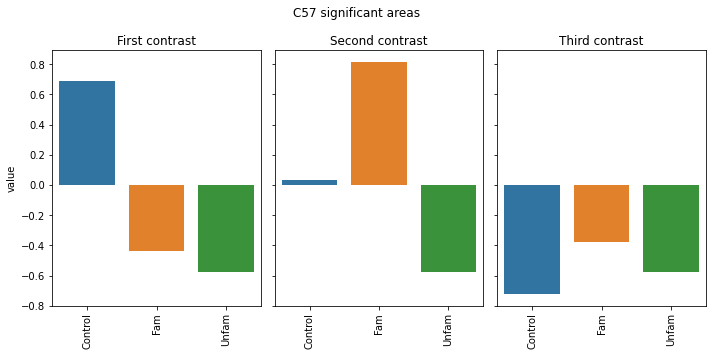

In [32]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.single_plot(df_data=c57_contrasts_filt, index=0, ax=axes[0])
upls.single_plot(df_data=c57_contrasts_filt, index=1, ax=axes[1])
upls.single_plot(df_data=c57_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
fig.suptitle('C57 significant areas')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_contrasts_sig_areas.png')

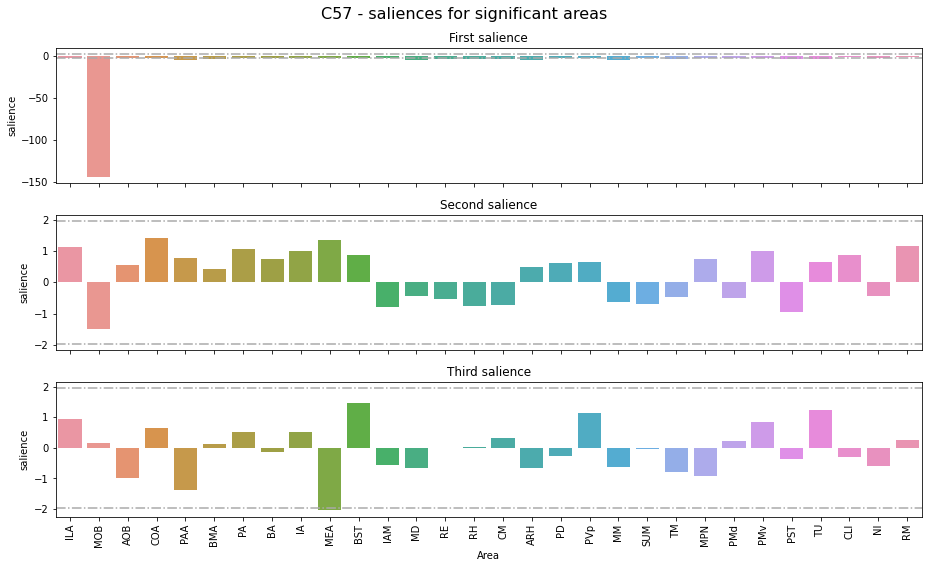

In [24]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,8))
plt.subplots_adjust(top=0.9, left=0.03, right=0.98)
upls.single_plot(df_data=c57_saliences_filt, index=0, ax=axes[0])
upls.single_plot(df_data=c57_saliences_filt, index=1, ax=axes[1])
upls.single_plot(df_data=c57_saliences_filt, index=2, ax=axes[2])
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
fig.suptitle('C57 - saliences for significant areas', fontsize=16)
for i in range(3):
    axes[i].set_ylabel('salience')
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.tight_layout()
plt.savefig('./results_pls/c57_pls_saliences_sig_areas.png')

# Identify areas with significant salience contribution

In [ ]:
pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=c57_saliences_filt, 
                                       threshold=1.96, 
                                       volumes=volumes)
pls_sig_areas_filt